# Deep Hedging V2 — Black-Scholes, Merton & Heston

Pipeline complet de Deep Hedging avec le package `deep_hedging/`.

### Nouveautes V2 vs V1
| Feature | V1 | V2 |
|---|---|---|
| Features d'etat | 2 (S_rel, time) | 6 (log-moneyness, time, delta_{t-1}, vol realisee, BS delta, d1) |
| Architectures | MLP uniquement | MLP + LSTM (recurrent) |
| Mondes | BS, Merton | BS, Merton, **Heston** (vol stochastique) |
| Payoffs | Call/Put | Call, Put, **Asian, Straddle, Lookback** |
| Loss | CVaR empirique | CVaR + **OCE parametrique** (seuil appris) |
| Metriques | 7 | **10** (+ Hedging Error, Sharpe PnL, Cost/Payoff) |
| Baselines | Delta BS | Delta BS + **No Hedge** |
| LR scheduler | Non | **ReduceLROnPlateau** |
| Action clipping | Non | **Oui** (plus/moins 2.0) |

### Pipeline
1. Configuration
2. Visualisation des trajectoires (BS, Merton, Heston)
3. Training MLP et LSTM (BS puis Merton)
4. Evaluation multi-scenarios (6 scenarios)
5. Analyse de risque (VaR, CVaR, KDE, QQ-plot)
6. Tableau de synthese colore (10 metriques)
7. Comparaison MLP vs LSTM
8. Bonus : payoffs exotiques

## 1. Imports et Configuration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import replace

from deep_hedging import (
    DEVICE, DTYPE, N_FEATURES,
    DeepHedgingConfig, MarketConfig, TrainingConfig, RandomConfig,
    SimpleWorldBS, SimpleWorldMerton, SimpleWorldHeston,
    DeepHedgingEnv, PolicyMLP, PolicyLSTM, DeltaBSPolicy,
    MonetaryUtility, OCEUtility,
    train_deep_hedging,
    evaluate_strategies_env_world, build_comparison_table,
    RiskMetrics,
    plot_training_history, plot_gains_hist, plot_payoff_vs_gains,
    plot_simulated_paths, traffic_light_style,
)

print(f"Device         : {DEVICE}")
print(f"Features / step: {N_FEATURES}")
print(f"Dtype          : {DTYPE}")

Device         : mps
Features / step: 6
Dtype          : torch.float32


## 2. Configuration globale

In [3]:
cfg = DeepHedgingConfig()

print("=== Marche ===")
print(f"  S0={cfg.market.S0}, sigma={cfg.market.sigma}, K={cfg.market.K}, T={cfg.market.T}")
print(f"  n_steps={cfg.market.n_steps}, cost_s={cfg.market.cost_s}")
print()
print("=== Merton ===")
print(f"  lambda_jump={cfg.market.lambda_jump}, mu_J={cfg.market.mu_J}, sigma_J={cfg.market.sigma_J}")
print()
print("=== Heston ===")
print(f"  kappa={cfg.market.heston_kappa}, theta={cfg.market.heston_theta}")
print(f"  xi={cfg.market.heston_xi}, rho={cfg.market.heston_rho}, v0={cfg.market.heston_v0}")
print()
print("=== Training ===")
print(f"  epochs={cfg.training.n_epochs}, batch_size={cfg.training.batch_size}")
print(f"  lr={cfg.training.lr}, CVaR alpha={cfg.training.cvar_alpha}")
print(f"  train paths={cfg.market.n_paths_train:,}, val paths={cfg.market.n_paths_val:,}")

=== Marche ===
  S0=100.0, sigma=0.2, K=100.0, T=1.0
  n_steps=52, cost_s=0.0002

=== Merton ===
  lambda_jump=1.0, mu_J=-0.1, sigma_J=0.3

=== Heston ===
  kappa=2.0, theta=0.04
  xi=0.3, rho=-0.7, v0=0.04

=== Training ===
  epochs=50, batch_size=10000
  lr=0.001, CVaR alpha=0.025
  train paths=200,000, val paths=50,000


## 3. Visualisation des trajectoires simulees

Comparaison visuelle des trois mondes avec les memes parametres.

### 3.1 Black-Scholes

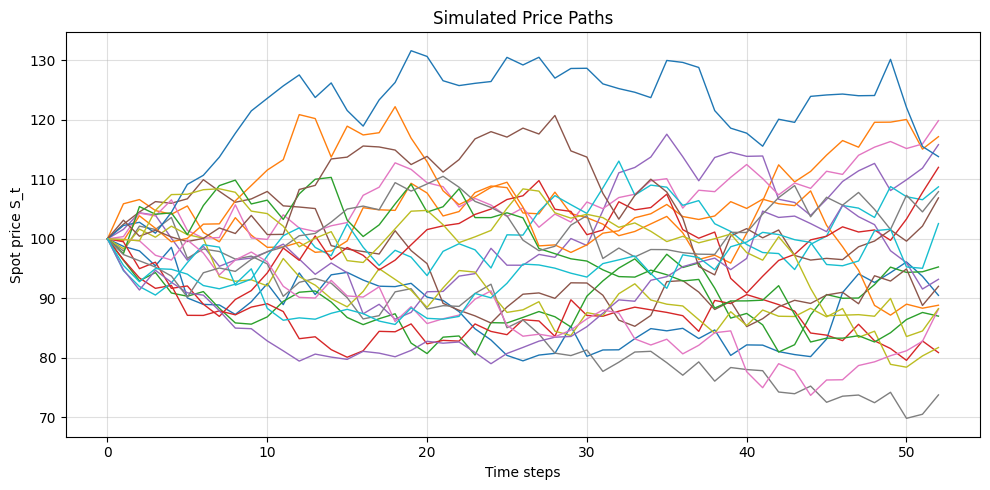

Payoff call moyen : 8.75


In [4]:
world_bs = SimpleWorldBS(cfg.market)
data_bs = world_bs.simulate_paths(200, seed=42)
plot_simulated_paths(data_bs["S"], n_paths_to_plot=20)
print(f"Payoff call moyen : {data_bs['payoff'].mean():.2f}")

### 3.2 Merton Jump-Diffusion

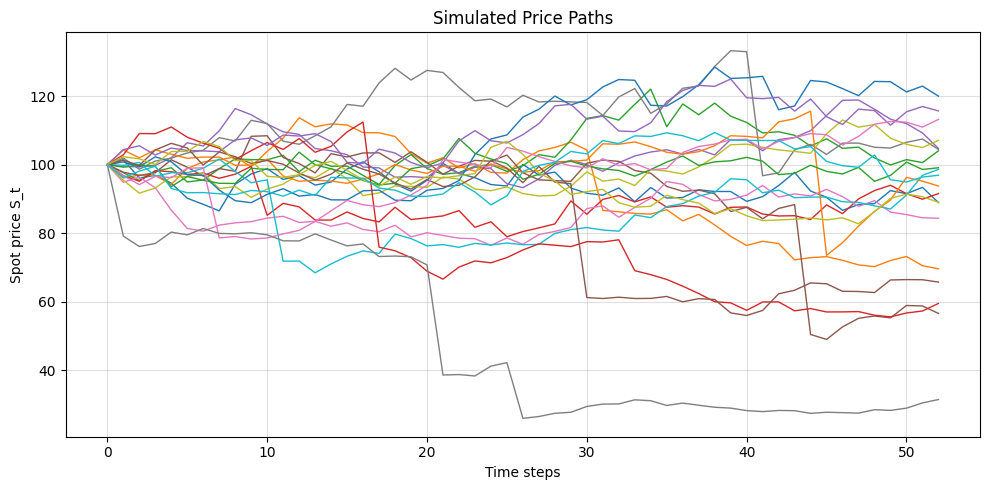

Payoff call moyen : 12.42


In [5]:
world_merton = SimpleWorldMerton(cfg.market)
data_merton = world_merton.simulate_paths(200, seed=42)
plot_simulated_paths(data_merton["S"], n_paths_to_plot=20)
print(f"Payoff call moyen : {data_merton['payoff'].mean():.2f}")

### 3.3 Heston Stochastic Volatility

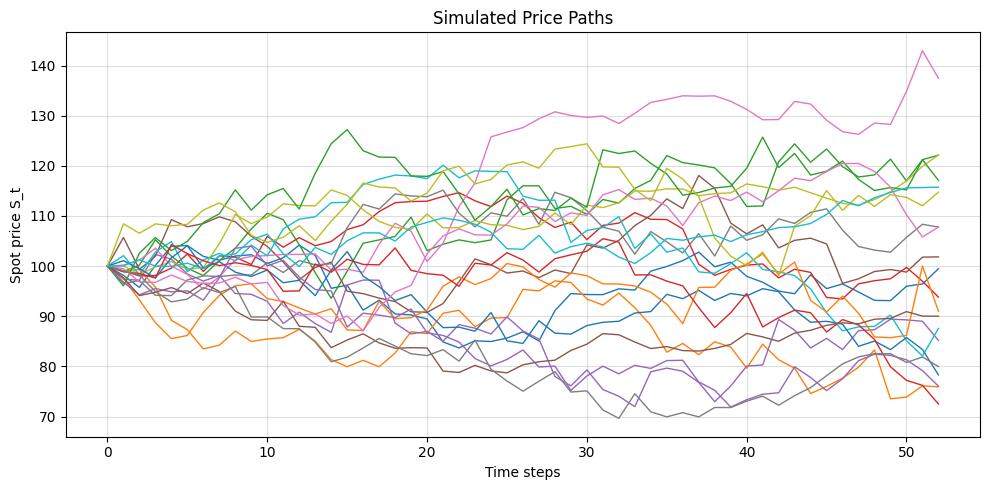

Payoff call moyen : 9.24


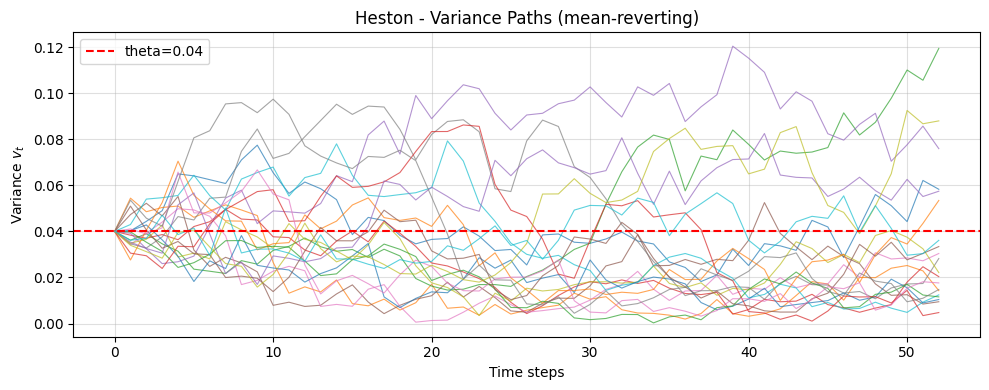

In [6]:
world_heston = SimpleWorldHeston(cfg.market)
data_heston = world_heston.simulate_paths(200, seed=42)
plot_simulated_paths(data_heston["S"], n_paths_to_plot=20)
print(f"Payoff call moyen : {data_heston['payoff'].mean():.2f}")

# Trajectoires de variance v_t
fig, ax = plt.subplots(figsize=(10, 4))
for i in range(20):
    ax.plot(data_heston["v"][i], linewidth=0.8, alpha=0.7)
ax.axhline(cfg.market.heston_theta, color="red", linestyle="--",
           label=f"theta={cfg.market.heston_theta}")
ax.set_xlabel("Time steps")
ax.set_ylabel("Variance $v_t$")
ax.set_title("Heston - Variance Paths (mean-reverting)")
ax.legend()
ax.grid(alpha=0.4)
plt.tight_layout()
plt.show()

## 4. Entrainement Deep Hedging

On entraine 4 modeles :
- MLP sous Black-Scholes
- LSTM sous Black-Scholes
- MLP sous Merton
- LSTM sous Merton

Chacun utilise les **6 features enrichies**, le **LR scheduler**, et l'**action clipping**.

### 4.1 MLP - Black-Scholes

MLP : 1313 params
Epoch   5/50 | train_loss=7.235690 | val_loss=2.060298 | lr=1.00e-03 | patience=1/5
Early stopping a l'epoch 9.


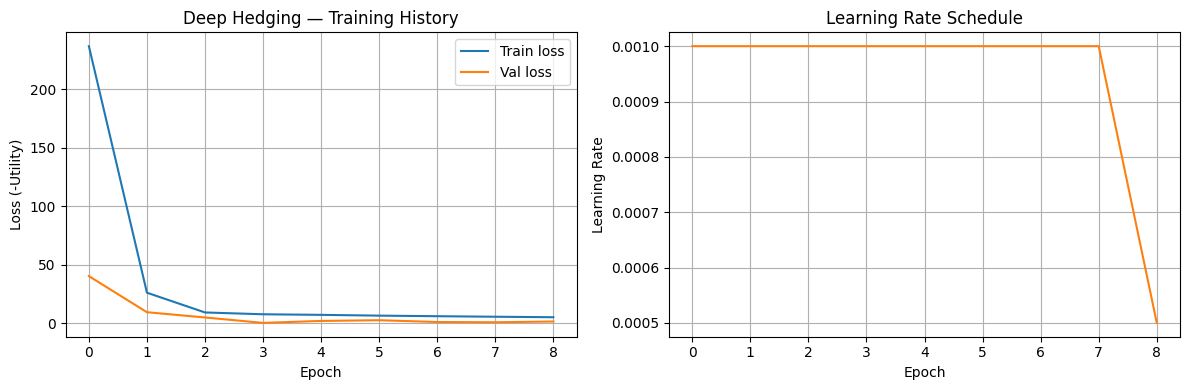

In [7]:
cfg_bs = DeepHedgingConfig(
    market=replace(cfg.market, use_jumps=False, payoff_type="call"),
    training=cfg.training,
    random=cfg.random,
    device=cfg.device,
    dtype=cfg.dtype,
)

policy_mlp_bs = PolicyMLP(
    d_in=N_FEATURES, d_hidden=32, depth=2, dropout=0.1, clip=2.0
)
print(f"MLP : {sum(p.numel() for p in policy_mlp_bs.parameters())} params")

res_mlp_bs = train_deep_hedging(
    cfg_bs, policy_mlp_bs,
    utility=MonetaryUtility(kind="cvar", alpha=cfg_bs.training.cvar_alpha),
    patience=5, min_delta=1e-3, use_scheduler=True,
)
plot_training_history(res_mlp_bs["history"])

### 4.2 LSTM - Black-Scholes

LSTM : 5153 params
Epoch   5/50 | train_loss=1.098013 | val_loss=0.829613 | lr=1.00e-03 | patience=0/5
Epoch  10/50 | train_loss=-0.585935 | val_loss=-0.853756 | lr=1.00e-03 | patience=0/5
Epoch  15/50 | train_loss=-2.084623 | val_loss=-1.998410 | lr=1.00e-03 | patience=1/5
Epoch  20/50 | train_loss=-2.750913 | val_loss=-2.990571 | lr=1.00e-03 | patience=0/5
Epoch  25/50 | train_loss=-3.191915 | val_loss=-3.244819 | lr=1.00e-03 | patience=0/5
Epoch  30/50 | train_loss=-3.117581 | val_loss=-2.874051 | lr=1.00e-03 | patience=3/5
Epoch  35/50 | train_loss=-3.314157 | val_loss=-3.537785 | lr=1.00e-03 | patience=0/5
Epoch  40/50 | train_loss=-3.493364 | val_loss=-3.663317 | lr=5.00e-04 | patience=0/5
Epoch  45/50 | train_loss=-3.838510 | val_loss=-3.846291 | lr=5.00e-04 | patience=0/5
Epoch  50/50 | train_loss=-3.868499 | val_loss=-3.751755 | lr=5.00e-04 | patience=3/5


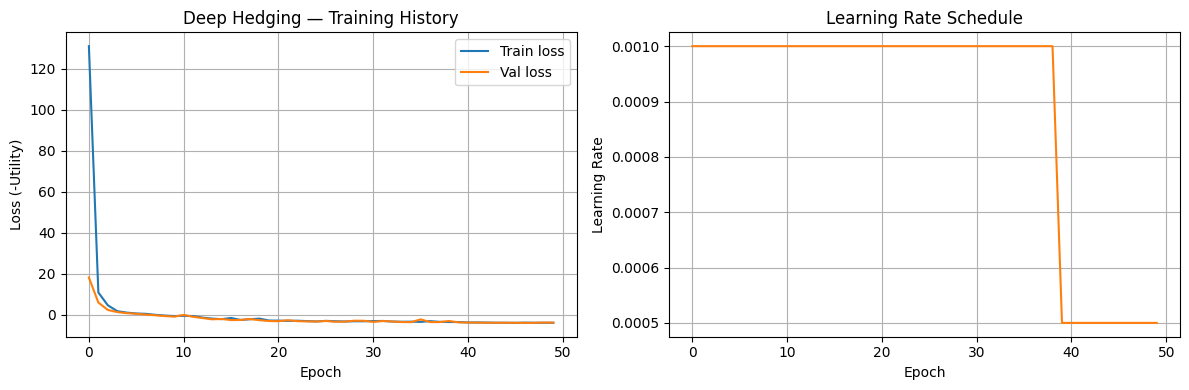

In [8]:
policy_lstm_bs = PolicyLSTM(
    d_in=N_FEATURES, d_hidden=32, n_layers=1, dropout=0.0, clip=2.0
)
print(f"LSTM : {sum(p.numel() for p in policy_lstm_bs.parameters())} params")

res_lstm_bs = train_deep_hedging(
    cfg_bs, policy_lstm_bs,
    utility=MonetaryUtility(kind="cvar", alpha=cfg_bs.training.cvar_alpha),
    patience=5, min_delta=1e-3, use_scheduler=True,
)
plot_training_history(res_lstm_bs["history"])

### 4.3 MLP - Merton (avec sauts)

Epoch   5/50 | train_loss=17.677987 | val_loss=12.384170 | lr=1.00e-03 | patience=2/5
Epoch  10/50 | train_loss=13.375281 | val_loss=11.179919 | lr=1.00e-03 | patience=1/5
Epoch  15/50 | train_loss=10.716662 | val_loss=9.990047 | lr=1.00e-03 | patience=1/5
Epoch  20/50 | train_loss=7.188484 | val_loss=1.295504 | lr=1.00e-03 | patience=0/5
Epoch  25/50 | train_loss=3.925589 | val_loss=0.886456 | lr=1.00e-03 | patience=2/5
Epoch  30/50 | train_loss=1.589820 | val_loss=-0.518416 | lr=1.00e-03 | patience=0/5
Epoch  35/50 | train_loss=-0.418347 | val_loss=-1.258850 | lr=1.00e-03 | patience=0/5
Epoch  40/50 | train_loss=-1.211184 | val_loss=-1.565275 | lr=1.00e-03 | patience=0/5
Epoch  45/50 | train_loss=-1.366826 | val_loss=-1.568264 | lr=1.00e-03 | patience=1/5
Epoch  50/50 | train_loss=-1.557052 | val_loss=-1.878231 | lr=1.00e-03 | patience=0/5


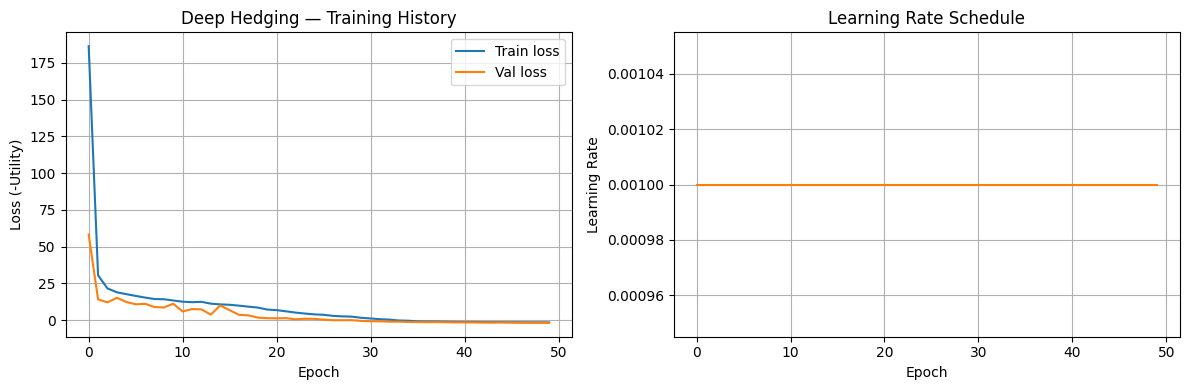

In [9]:
cfg_merton = DeepHedgingConfig(
    market=replace(cfg.market, use_jumps=True, payoff_type="call"),
    training=cfg.training,
    random=cfg.random,
    device=cfg.device,
    dtype=cfg.dtype,
)

policy_mlp_merton = PolicyMLP(
    d_in=N_FEATURES, d_hidden=32, depth=2, dropout=0.1, clip=2.0
)

res_mlp_merton = train_deep_hedging(
    cfg_merton, policy_mlp_merton,
    utility=MonetaryUtility(kind="cvar", alpha=cfg_merton.training.cvar_alpha),
    patience=5, min_delta=1e-3, use_scheduler=True,
)
plot_training_history(res_mlp_merton["history"])

### 4.4 LSTM - Merton (avec sauts)

Epoch   5/50 | train_loss=0.720471 | val_loss=1.013216 | lr=1.00e-03 | patience=1/5
Epoch  10/50 | train_loss=-0.409335 | val_loss=-0.612666 | lr=1.00e-03 | patience=0/5
Epoch  15/50 | train_loss=-1.491911 | val_loss=-1.655805 | lr=1.00e-03 | patience=0/5
Epoch  20/50 | train_loss=-2.315877 | val_loss=-1.842798 | lr=1.00e-03 | patience=1/5
Epoch  25/50 | train_loss=-2.590777 | val_loss=-2.852139 | lr=1.00e-03 | patience=0/5
Epoch  30/50 | train_loss=-1.253138 | val_loss=-2.723222 | lr=1.00e-03 | patience=1/5
Early stopping a l'epoch 34.


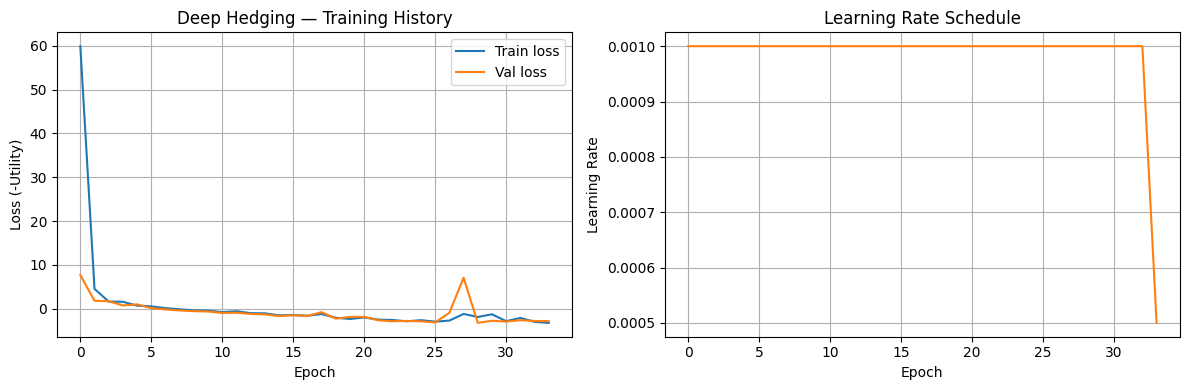

In [10]:
policy_lstm_merton = PolicyLSTM(
    d_in=N_FEATURES, d_hidden=32, n_layers=1, dropout=0.0, clip=2.0
)

res_lstm_merton = train_deep_hedging(
    cfg_merton, policy_lstm_merton,
    utility=MonetaryUtility(kind="cvar", alpha=cfg_merton.training.cvar_alpha),
    patience=5, min_delta=1e-3, use_scheduler=True,
)
plot_training_history(res_lstm_merton["history"])

## 5. Evaluation multi-scenarios

Six scenarios pour mesurer performance et robustesse :

| Scenario | Train | Test | Mesure |
|---|---|---|---|
| MLP BS->BS | BS | BS | Performance in-sample |
| LSTM BS->BS | BS | BS | LSTM vs MLP |
| MLP BS->Merton | BS | Merton | Robustesse aux sauts |
| MLP Merton->Merton | Merton | Merton | Performance in-sample |
| LSTM Merton->Merton | Merton | Merton | LSTM vs MLP |
| MLP Merton->Heston | Merton | Heston | Cross-model |

Chaque evaluation inclut **No Hedge**, **Delta BS**, **Deep Hedging**.

### 5.1 MLP : BS -> BS

=== MLP : BS -> BS ===
  CVaR Deep    : -0.3702
  CVaR Delta   : -10.7183
  CVaR No Hedge: 0.0000


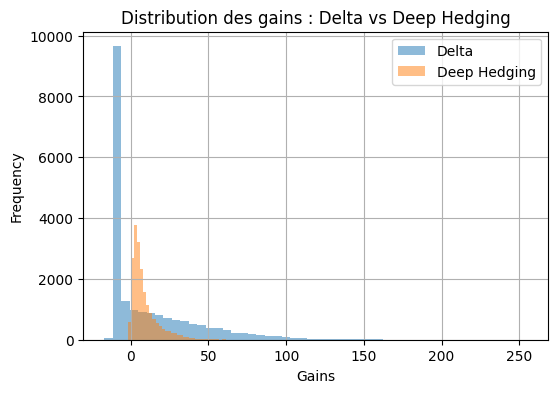

In [11]:
eval_mlp_bs_bs = evaluate_strategies_env_world(
    cfg_bs, res_mlp_bs["policy"],
    world_class=SimpleWorldBS,
    n_paths_eval=20_000,
    seed_eval=cfg_bs.random.seed_eval_bs,
)
print("=== MLP : BS -> BS ===")
print(f"  CVaR Deep    : {eval_mlp_bs_bs['cvar_deep']:.4f}")
print(f"  CVaR Delta   : {eval_mlp_bs_bs['cvar_delta']:.4f}")
print(f"  CVaR No Hedge: {eval_mlp_bs_bs['cvar_no_hedge']:.4f}")
plot_gains_hist(eval_mlp_bs_bs)

### 5.2 LSTM : BS -> BS

=== LSTM : BS -> BS ===
  CVaR Deep  : 3.8863
  CVaR Delta : -10.7183


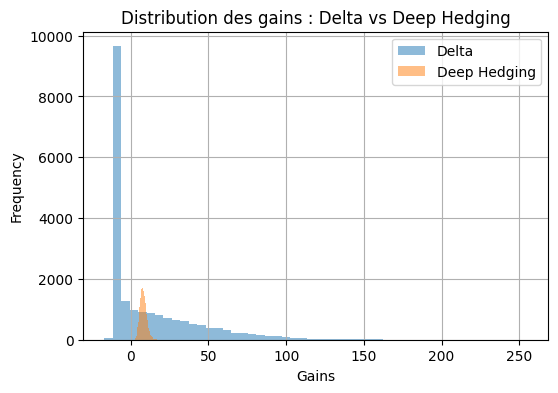

In [12]:
eval_lstm_bs_bs = evaluate_strategies_env_world(
    cfg_bs, res_lstm_bs["policy"],
    world_class=SimpleWorldBS,
    n_paths_eval=20_000,
    seed_eval=cfg_bs.random.seed_eval_bs,
)
print("=== LSTM : BS -> BS ===")
print(f"  CVaR Deep  : {eval_lstm_bs_bs['cvar_deep']:.4f}")
print(f"  CVaR Delta : {eval_lstm_bs_bs['cvar_delta']:.4f}")
plot_gains_hist(eval_lstm_bs_bs)

### 5.3 MLP : BS -> Merton (robustesse)

=== MLP : BS -> Merton ===
  CVaR Deep    : -4.5117
  CVaR Delta   : -43.3814
  CVaR No Hedge: 0.0000


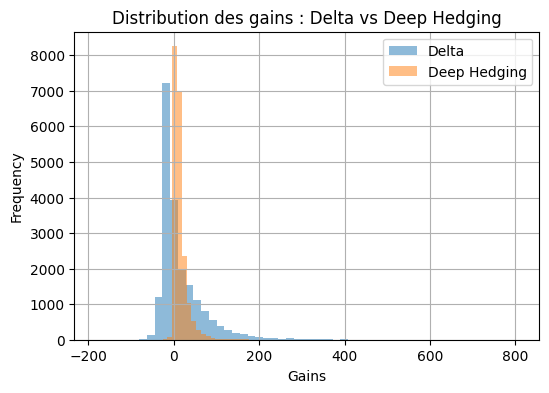

In [13]:
eval_mlp_bs_merton = evaluate_strategies_env_world(
    cfg_bs, res_mlp_bs["policy"],
    world_class=SimpleWorldMerton,
    n_paths_eval=20_000,
    seed_eval=cfg_bs.random.seed_eval_bs_merton,
)
print("=== MLP : BS -> Merton ===")
print(f"  CVaR Deep    : {eval_mlp_bs_merton['cvar_deep']:.4f}")
print(f"  CVaR Delta   : {eval_mlp_bs_merton['cvar_delta']:.4f}")
print(f"  CVaR No Hedge: {eval_mlp_bs_merton['cvar_no_hedge']:.4f}")
plot_gains_hist(eval_mlp_bs_merton)

### 5.4 MLP : Merton -> Merton

=== MLP : Merton -> Merton ===
  CVaR Deep  : 1.8656
  CVaR Delta : -43.3814


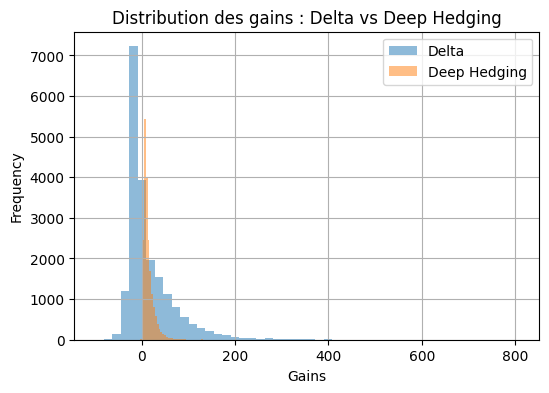

In [14]:
eval_mlp_merton_merton = evaluate_strategies_env_world(
    cfg_merton, res_mlp_merton["policy"],
    world_class=SimpleWorldMerton,
    n_paths_eval=20_000,
    seed_eval=cfg_merton.random.seed_eval_merton,
)
print("=== MLP : Merton -> Merton ===")
print(f"  CVaR Deep  : {eval_mlp_merton_merton['cvar_deep']:.4f}")
print(f"  CVaR Delta : {eval_mlp_merton_merton['cvar_delta']:.4f}")
plot_gains_hist(eval_mlp_merton_merton)

### 5.5 LSTM : Merton -> Merton

=== LSTM : Merton -> Merton ===
  CVaR Deep  : 3.1583
  CVaR Delta : -43.3814


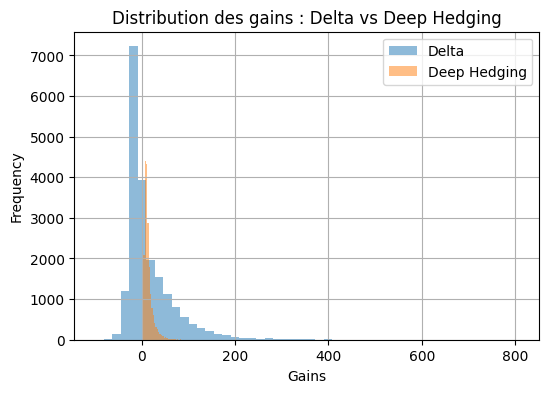

In [15]:
eval_lstm_merton_merton = evaluate_strategies_env_world(
    cfg_merton, res_lstm_merton["policy"],
    world_class=SimpleWorldMerton,
    n_paths_eval=20_000,
    seed_eval=cfg_merton.random.seed_eval_merton,
)
print("=== LSTM : Merton -> Merton ===")
print(f"  CVaR Deep  : {eval_lstm_merton_merton['cvar_deep']:.4f}")
print(f"  CVaR Delta : {eval_lstm_merton_merton['cvar_delta']:.4f}")
plot_gains_hist(eval_lstm_merton_merton)

### 5.6 MLP : Merton -> Heston (cross-model)

=== MLP : Merton -> Heston ===
  CVaR Deep    : 1.3744
  CVaR Delta   : -12.8389
  CVaR No Hedge: 0.0000


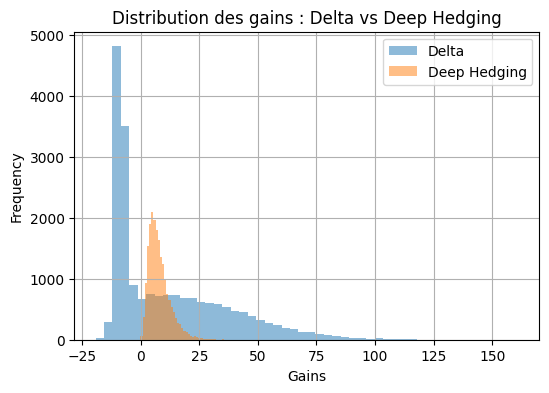

In [16]:
eval_mlp_merton_heston = evaluate_strategies_env_world(
    cfg_merton, res_mlp_merton["policy"],
    world_class=SimpleWorldHeston,
    n_paths_eval=20_000,
    seed_eval=cfg_merton.random.seed_eval_merton,
)
print("=== MLP : Merton -> Heston ===")
print(f"  CVaR Deep    : {eval_mlp_merton_heston['cvar_deep']:.4f}")
print(f"  CVaR Delta   : {eval_mlp_merton_heston['cvar_delta']:.4f}")
print(f"  CVaR No Hedge: {eval_mlp_merton_heston['cvar_no_hedge']:.4f}")
plot_gains_hist(eval_mlp_merton_heston)

## 6. Analyse de risque detaillee

Focus sur **Merton -> Merton** : comparaison Delta BS / MLP / LSTM.

In [21]:
rm = RiskMetrics(alpha=cfg.training.cvar_alpha)

gains_delta = eval_mlp_merton_merton["gains_delta"]
gains_mlp   = eval_mlp_merton_merton["gains_deep"]
gains_lstm  = eval_lstm_merton_merton["gains_deep"]

for name, g in [("Delta BS", gains_delta), ("Deep MLP", gains_mlp), ("Deep LSTM", gains_lstm)]:
    s = rm.summary(g)
    print(f"  VaR={s['VaR']:.2f}  CVaR={s['CVaR']:.2f}")

  VaR=-35.12  CVaR=-43.38
  VaR=2.54  CVaR=1.87
  VaR=4.02  CVaR=3.16


### 6.1 Histogrammes avec VaR

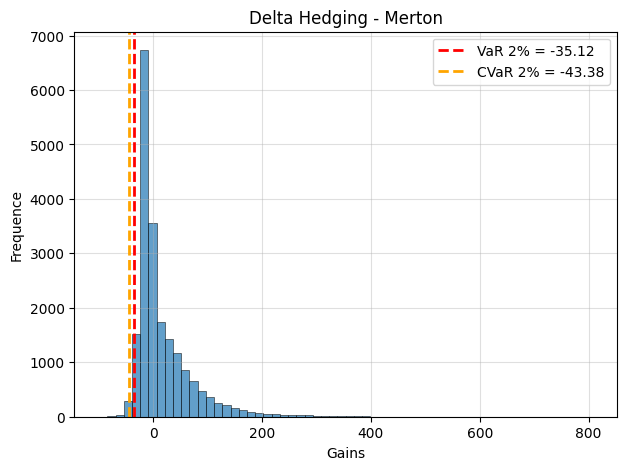

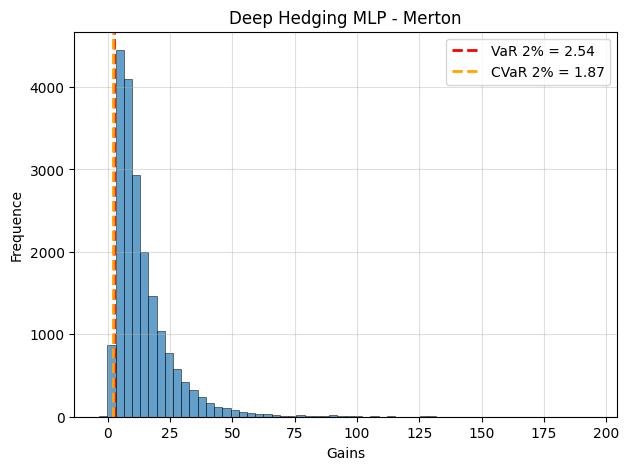

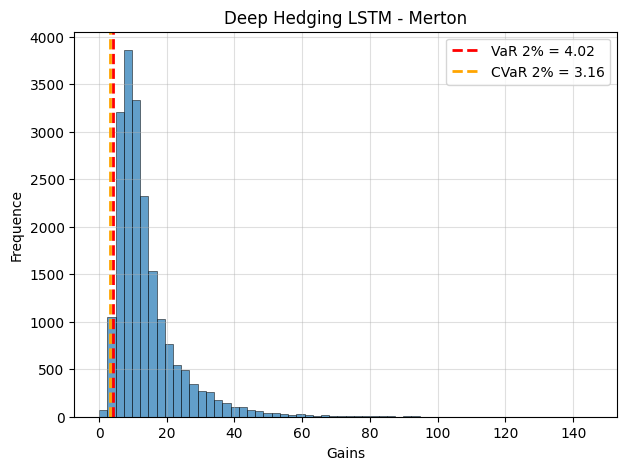

In [22]:
rm.plot_hist_with_var(gains_delta, title="Delta Hedging - Merton")
rm.plot_hist_with_var(gains_mlp,  title="Deep Hedging MLP - Merton")
rm.plot_hist_with_var(gains_lstm, title="Deep Hedging LSTM - Merton")

### 6.2 KDE : comparaisons deux a deux

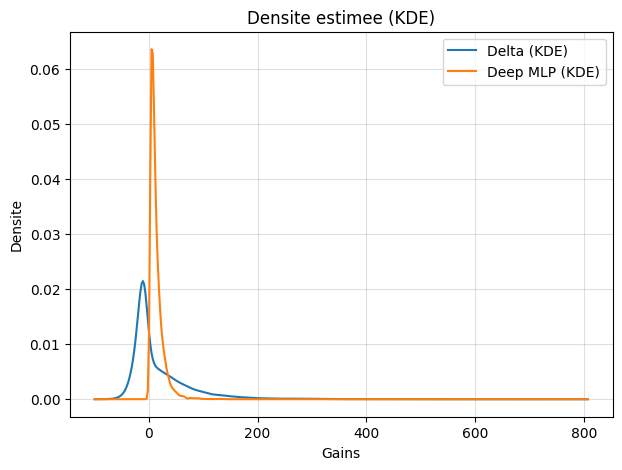

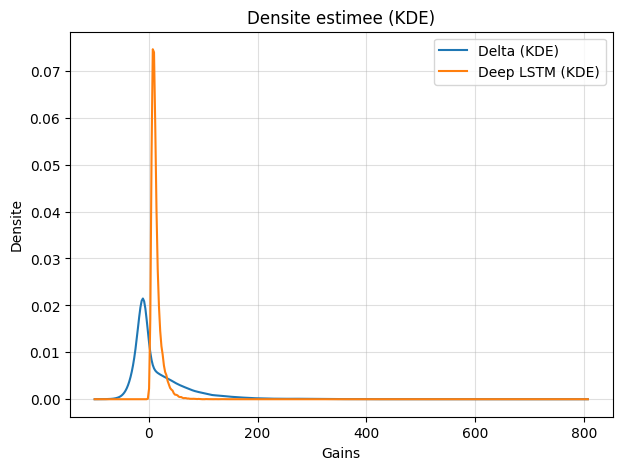

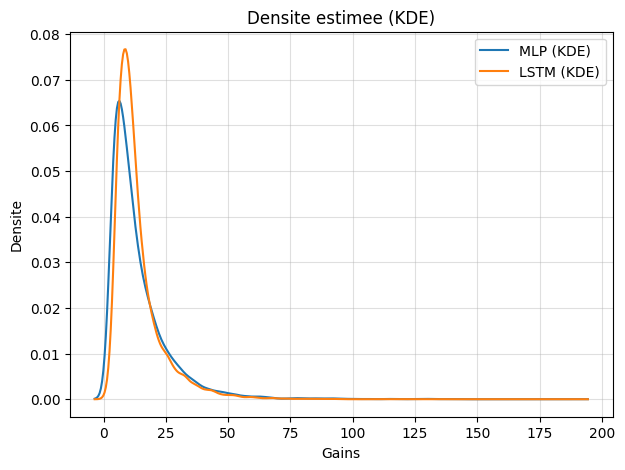

In [23]:
rm.plot_kde(gains_delta, gains_mlp, label_a="Delta", label_b="Deep MLP")
rm.plot_kde(gains_delta, gains_lstm, label_a="Delta", label_b="Deep LSTM")
rm.plot_kde(gains_mlp, gains_lstm, label_a="MLP", label_b="LSTM")

### 6.3 QQ-Plots vs distribution normale

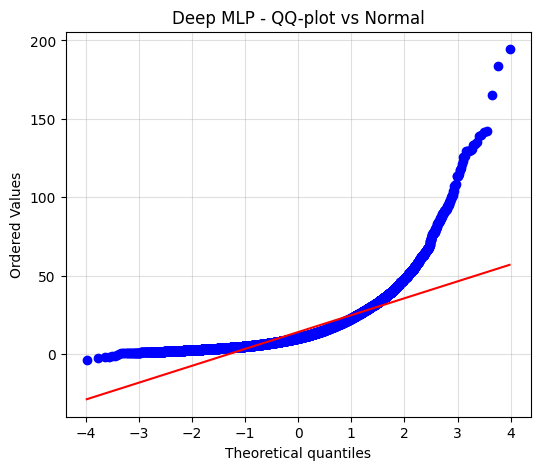

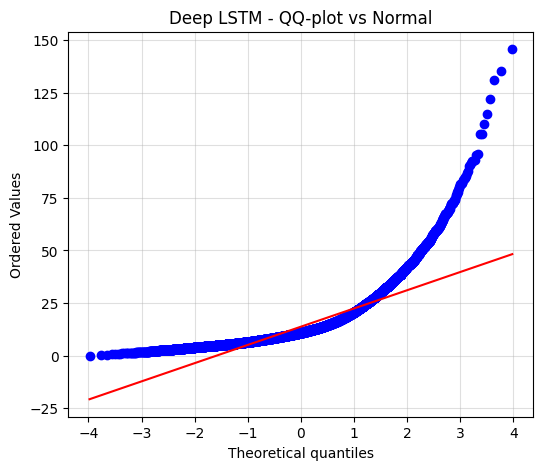

In [24]:
rm.plot_qq(gains_mlp, title="Deep MLP - QQ-plot vs Normal")
rm.plot_qq(gains_lstm, title="Deep LSTM - QQ-plot vs Normal")

### 6.4 Queue gauche (tail risk)

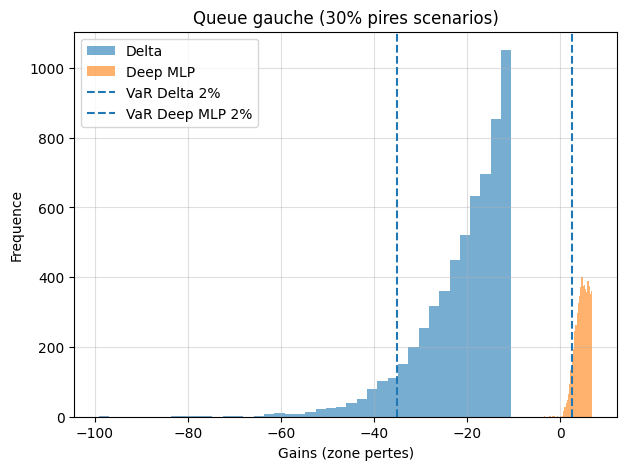

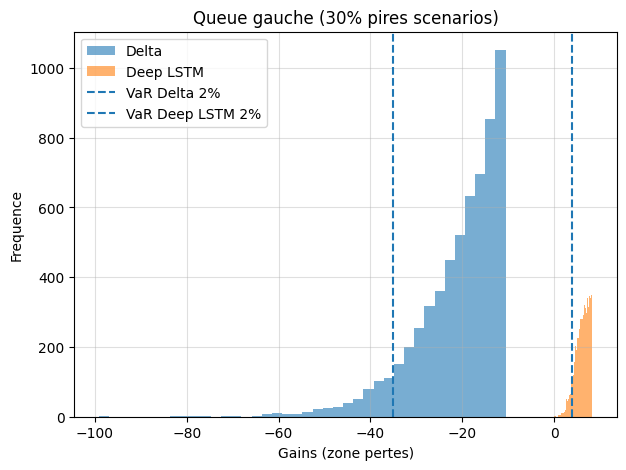

In [25]:
rm.plot_left_tail(gains_delta, gains_mlp, label_a="Delta", label_b="Deep MLP")
rm.plot_left_tail(gains_delta, gains_lstm, label_a="Delta", label_b="Deep LSTM")

## 7. Tableau de synthese

Comparaison coloree (traffic light) : 3 strategies x 6 scenarios x 10 metriques.

In [26]:
scenarios = {
    "MLP BS->BS":           (cfg_bs,     eval_mlp_bs_bs),
    "LSTM BS->BS":          (cfg_bs,     eval_lstm_bs_bs),
    "MLP BS->Merton":       (cfg_bs,     eval_mlp_bs_merton),
    "MLP Merton->Merton":   (cfg_merton, eval_mlp_merton_merton),
    "LSTM Merton->Merton":  (cfg_merton, eval_lstm_merton_merton),
    "MLP Merton->Heston":   (cfg_merton, eval_mlp_merton_heston),
}

all_tables = []
for scenario_name, (c, ev) in scenarios.items():
    t = build_comparison_table(c, ev).copy()
    t.insert(0, "Scenario", scenario_name)
    all_tables.append(t)

summary_df = pd.concat(all_tables, axis=0)
summary_df = summary_df.reset_index().rename(columns={"index": "Strategy"})
summary_df = summary_df.set_index(["Scenario", "Strategy"])

styled = (
    summary_df.astype(float)
    .style
    .apply(traffic_light_style, axis=None)
    .format("{:.4f}")
)
display(styled)

## 8. Comparaison directe MLP vs LSTM

Resume des performances cles pour les deux architectures.

In [27]:
comparison_data = {
    "Scenario": ["BS->BS", "BS->BS", "Merton->Merton", "Merton->Merton"],
    "Architecture": ["MLP", "LSTM", "MLP", "LSTM"],
    "CVaR Deep": [
        eval_mlp_bs_bs["cvar_deep"],
        eval_lstm_bs_bs["cvar_deep"],
        eval_mlp_merton_merton["cvar_deep"],
        eval_lstm_merton_merton["cvar_deep"],
    ],
    "Std Deep": [
        eval_mlp_bs_bs["std_deep"],
        eval_lstm_bs_bs["std_deep"],
        eval_mlp_merton_merton["std_deep"],
        eval_lstm_merton_merton["std_deep"],
    ],
    "CVaR Delta (ref)": [
        eval_mlp_bs_bs["cvar_delta"],
        eval_lstm_bs_bs["cvar_delta"],
        eval_mlp_merton_merton["cvar_delta"],
        eval_lstm_merton_merton["cvar_delta"],
    ],
}

comp_df = pd.DataFrame(comparison_data).set_index(["Scenario", "Architecture"])
print(comp_df.round(4).to_string())
print()
print("Note: un CVaR plus eleve (moins negatif) = meilleur tail risk.")

                             CVaR Deep  Std Deep  CVaR Delta (ref)
Scenario       Architecture                                       
BS->BS         MLP             -0.3702    8.7263          -10.7183
               LSTM             3.8863    2.1294          -10.7183
Merton->Merton MLP              1.8656   12.6129          -43.3814
               LSTM             3.1583    9.9299          -43.3814

Note: un CVaR plus eleve (moins negatif) = meilleur tail risk.


## 9. Bonus : Deep Hedging sur payoffs exotiques

Entrainement rapide du MLP sur 5 payoffs differents sous Black-Scholes :
- **Call** : max(S_T - K, 0)
- **Put** : max(K - S_T, 0)
- **Straddle** : |S_T - K|
- **Asian** : max(mean(S) - K, 0)  *(path-dependent)*
- **Lookback** : max(max(S) - K, 0)  *(path-dependent)*

In [28]:
exotic_results = {}

for ptype in ["call", "put", "straddle", "asian", "lookback"]:
    print(f"\n--- Payoff: {ptype.upper()} ---")
    cfg_exotic = DeepHedgingConfig(
        market=replace(cfg.market, use_jumps=False, payoff_type=ptype,
                       n_paths_train=50_000, n_paths_val=10_000),
        training=replace(cfg.training, n_epochs=30, print_every=10),
        random=cfg.random,
        device=cfg.device,
        dtype=cfg.dtype,
    )

    pol = PolicyMLP(d_in=N_FEATURES, d_hidden=32, depth=2, dropout=0.1, clip=2.0)
    res = train_deep_hedging(cfg_exotic, pol, patience=5, use_scheduler=True)

    ev = evaluate_strategies_env_world(
        cfg_exotic, res["policy"],
        world_class=SimpleWorldBS,
        n_paths_eval=10_000,
        seed_eval=42,
    )
    exotic_results[ptype] = ev

# Tableau recap
exotic_summary = pd.DataFrame({
    ptype: {
        "CVaR Deep": ev["cvar_deep"],
        "CVaR Delta": ev["cvar_delta"],
        "CVaR No Hedge": ev["cvar_no_hedge"],
        "Std Deep": ev["std_deep"],
        "Std Delta": ev["std_delta"],
    }
    for ptype, ev in exotic_results.items()
}).T

print("\n=== Recap payoffs exotiques ===")
print(exotic_summary.round(4).to_string())


--- Payoff: CALL ---
Epoch  10/30 | train_loss=7.934157 | val_loss=3.202053 | lr=1.00e-03 | patience=0/5
Early stopping a l'epoch 17.

--- Payoff: PUT ---
Epoch  10/30 | train_loss=8.516457 | val_loss=8.030513 | lr=1.00e-03 | patience=0/5
Epoch  20/30 | train_loss=6.636379 | val_loss=5.258924 | lr=5.00e-04 | patience=5/5
Early stopping a l'epoch 20.

--- Payoff: STRADDLE ---
Epoch  10/30 | train_loss=0.427920 | val_loss=-1.113162 | lr=5.00e-04 | patience=5/5
Early stopping a l'epoch 10.

--- Payoff: ASIAN ---
Epoch  10/30 | train_loss=14.620480 | val_loss=14.808275 | lr=1.00e-03 | patience=1/5
Early stopping a l'epoch 19.

--- Payoff: LOOKBACK ---
Epoch  10/30 | train_loss=4.137972 | val_loss=3.210733 | lr=1.00e-03 | patience=0/5
Epoch  20/30 | train_loss=2.219058 | val_loss=-0.135474 | lr=1.00e-03 | patience=3/5
Epoch  30/30 | train_loss=0.918759 | val_loss=-2.319338 | lr=1.00e-03 | patience=0/5

=== Recap payoffs exotiques ===
          CVaR Deep  CVaR Delta  CVaR No Hedge  Std Deep

## 10. Sauvegarde des modeles

In [29]:
checkpoint = {
    "policy_mlp_bs": res_mlp_bs["policy"].state_dict(),
    "policy_lstm_bs": res_lstm_bs["policy"].state_dict(),
    "policy_mlp_merton": res_mlp_merton["policy"].state_dict(),
    "policy_lstm_merton": res_lstm_merton["policy"].state_dict(),
    "config_bs": cfg_bs,
    "config_merton": cfg_merton,
    "history_mlp_bs": res_mlp_bs["history"],
    "history_lstm_bs": res_lstm_bs["history"],
    "history_mlp_merton": res_mlp_merton["history"],
    "history_lstm_merton": res_lstm_merton["history"],
}

torch.save(checkpoint, "deep_hedging_models_v2.pt")
print(f"Checkpoint sauvegarde : deep_hedging_models_v2.pt")
print(f"Contient {len(checkpoint)} elements")

Checkpoint sauvegarde : deep_hedging_models_v2.pt
Contient 10 elements


## Conclusion

Ce notebook V2 orchestre le pipeline complet de Deep Hedging enrichi :

| Composant | Details |
|---|---|
| **Mondes** | Black-Scholes, Merton Jump-Diffusion, Heston Stochastic Vol |
| **Architectures** | MLP (feed-forward) et LSTM (recurrent) |
| **Features** | 6D enrichies : log-moneyness, time, prev_delta, realized_vol, BS delta, d1 |
| **Losses** | CVaR empirique, entropique, OCE parametrique |
| **Payoffs** | Call, Put, Straddle, Asian, Lookback |
| **Evaluation** | 3 strategies x 6 scenarios x 10 metriques |
| **Risk** | VaR, CVaR, KDE, QQ-plot, queue gauche |

### Structure du package

```
deep_hedging/
  __init__.py      # Public API
  config.py        # BS + Merton + Heston + payoff_type
  worlds.py        # BS, Merton, Heston + payoffs exotiques
  env.py           # 6 features enrichies
  policies.py      # MLP, LSTM, DeltaBS (avec clipping)
  losses.py        # CVaR, entropique, OCE parametrique
  training.py      # DataLoader + early stop + LR scheduler
  evaluation.py    # No Hedge + Delta + Deep, 10 metriques
  risk_metrics.py  # VaR, CVaR, histogrammes, KDE, QQ-plot
  plotting.py      # Visualisations + traffic light
  utils.py         # Fonctions utilitaires
```